In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys

sys.path.append('../src')
from sim import make_dataset
from utils import show_dataset

In [2]:
import torch
from torch import nn
from base import buildmethod, HotTopic
from nets import OPTIM, MLP
from utils import shuffle

class Encoder(nn.Module):
    def __init__(self, in_channels, wc_channels=(128, 128), bc_channels=(512, 512), lp_channels=(128, 128), act_layer='prelu'):
        super().__init__()

        self.in_channels = in_channels
        self.wc_channels = wc_channels
        self.bc_channels = bc_channels
        self.lp_channels = lp_channels
        self.act_layer = act_layer

        if self.lp_channels[-1] != 1:
            self.lp_channels += (1,)

        self._wc_model = MLP(self.in_channels, *self.wc_channels, act_layer=self.act_layer)
        self._us_model = MLP(self.in_channels, *self.wc_channels, act_layer=self.act_layer)
        self._bc_model = MLP(self.wc_channels[-1], *self.bc_channels, act_layer=self.act_layer)
        self._lp_model = MLP(self.wc_channels[-1] + self.bc_channels[-1], *self.lp_channels, act_layer=self.act_layer, final_bias=False)

    def _build(self, X):
        self._batch_size = X.shape[0] if X.ndim > 2 else 1
        self._n_samples, self.n_topics_ = X.shape[-2], 1
        self._topic_range = torch.arange(self.n_topics_)
        self._wc, self._us = self._wc_model(X), self._us_model(X)
        self._WC = torch.zeros((self._batch_size, 1, self.wc_channels[-1]))
        self._WC[:, 0], self._US = self._wc[:, 0], self._us[:, 2:].sum(1)

        return self
    
    def _update(self, idx, topics):
        n_topics = topics[:idx].unique().shape[0]

        if n_topics == self.n_topics_:
            self._WC[:, topics[idx - 1]] += self._wc[:, idx - 1]
        else:
            self._WC = torch.cat((self._WC, self._wc[:, idx - 1].unsqueeze(1)), 1)

        if idx == self._n_samples - 1:
            self._US = torch.zeros((self._batch_size, self.wc_channels[-1]))
        else:
            self._US -= self._us[:, idx]

        self.n_topics_, self._topic_range = n_topics, torch.arange(n_topics)

        return n_topics
    
    def _logprobs(self, idx):
        WC_k = self._WC.repeat(self.n_topics_, 1, 1, 1)
        WC_k[self._topic_range, :, self._topic_range] += self._wc[:, idx]
        WC_K = torch.cat((self._WC, self._wc[:, idx].unsqueeze(1)), 1)
        BC_k, BC_K = self._bc_model(WC_k).sum(2), self._bc_model(WC_K).sum(1)
        US_k = self._US.repeat(self.n_topics_, 1, 1)
        logprobs = torch.zeros((self._batch_size, self.n_topics_ + 1))
        logprobs[:, :-1] = self._lp_model(torch.cat((BC_k, US_k), -1))[..., 0].T
        logprobs[:, -1] = self._lp_model(torch.cat((BC_K, self._US), 1)).squeeze()
        m, _ = logprobs.max(1, keepdim=True)
        logprobs = logprobs - m - (logprobs - m).exp().sum(1, keepdim=True).log()

        return logprobs
    
    @buildmethod
    def evaluate(self, X, y):
        nll = 0

        for i in range(1, self._n_samples):  # TODO: this should probably start from 1
            self._update(i, y)
            logprobs = self._logprobs(i)
            nll -= logprobs[:, y[i]].mean()

        return nll
    
    @buildmethod
    def forward(self, X):
        z = torch.zeros(X.shape[-2], dtype=torch.int32)

        for i in range(1, self._n_samples):
            self._update(i, z)
            probs = self._logprobs(i).exp()
            z[i] = probs.multinomial(1).squeeze().mode().values.item()

        return z

class UNCP(HotTopic, nn.Module):
    def __init__(self, wc_channels=(128, 128), bc_channels=(512, 512), lp_channels=(128, 128), act_layer='prelu', optim='adam', desc='NCP'):
        super().__init__(desc, check=False)

        self.wc_channels = wc_channels
        self.bc_channels = bc_channels
        self.lp_channels = lp_channels
        self.act_layer = act_layer
        self.optim = optim

        self._n_steps = 200

    def _build(self, X, learning_rate=1e-4, weight_decay=1e-2, batch_size=16):
        self._batch_size = X.shape[0] if X.ndim > 2 and X.shape[0] > 1 else batch_size
        self._encoder = Encoder(X.shape[-1], self.wc_channels, self.bc_channels, self.lp_channels, self.act_layer)
        self._optim = OPTIM[self.optim](self.parameters(), lr=learning_rate, weight_decay=weight_decay)

        return self
    
    def _step(self, X, y, n_perms=6, n_samples=64):
        mask, nll = torch.randperm(X.shape[0])[:self._batch_size], 0

        for _ in range(n_perms):
            data, labels = shuffle(X[mask], y, sort=True, cut=n_samples)
            perm_nll = self._encoder.evaluate(data, labels)
            perm_nll.backward()
            nll += perm_nll.item()

        self._optim.step()
        self._optim.zero_grad()

        return nll
    
    def _predict(self, X):
        if X.ndim < 3 or X.shape[0] == 1:
            X = X.repeat(self._batch_size, 1, 1)

        topics = self._encoder(X)

        return topics
    
    def forward(self, X):
        topics = self._predict(X)

        return topics

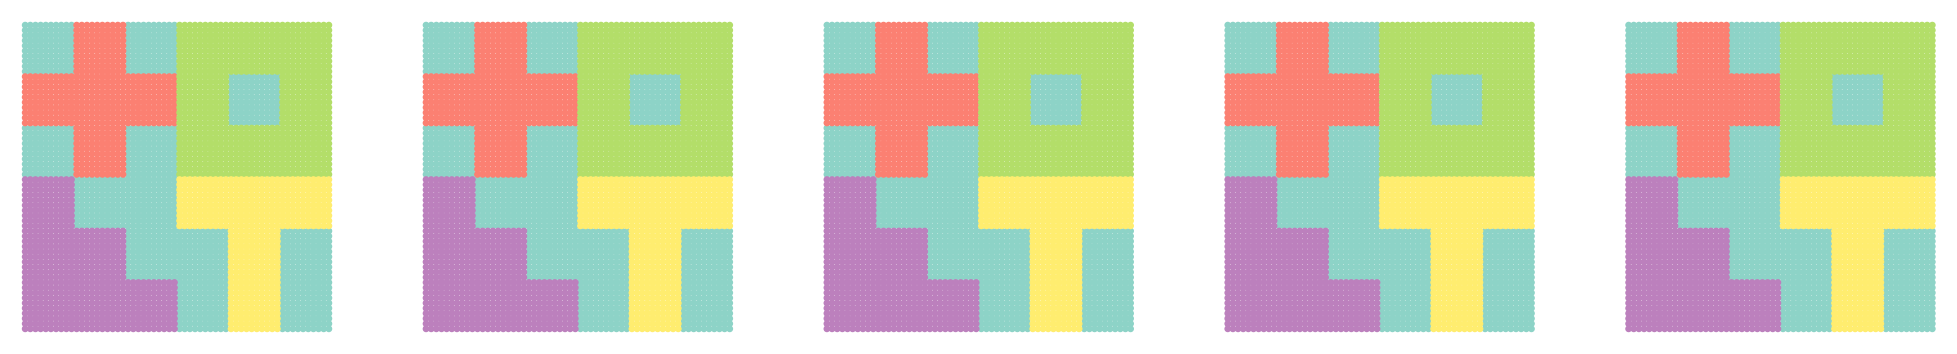

In [3]:
N_DATASETS = 4
TEMPLATE = ('polygons',) + ('polygons',)*N_DATASETS
BLOCK_SIZE = (10, 10)

data, labels = make_dataset(TEMPLATE, n_features=3, block_size=BLOCK_SIZE, return_tensor=True)

X = data[data[data[:, 0] == 0].shape[0]:]
X = X.view(N_DATASETS, X.shape[0]//N_DATASETS, X.shape[-1])[..., 3:]
y = labels[data[data[:, 0] == 0].shape[0]:data[data[:, 0] == 0].shape[0] + X.shape[1]]
z = data[:data[data[:, 0] == 0].shape[0]]
z_locations, z_features = z[:, :3], z[None][..., 3:]

show_dataset(data, labels, sectioned=True)

NCP: 100%|██████████| 200/200 [01:41<00:00,  1.96it/s]


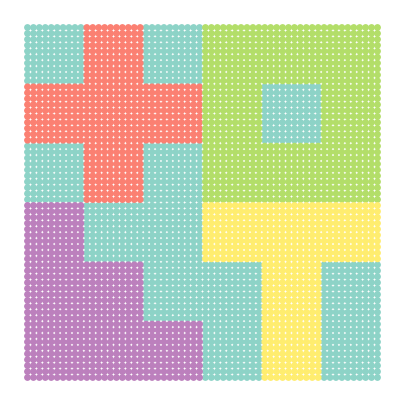

In [4]:
model = UNCP()
topics = model.fit(X, y)(z_features)
show_dataset(z_locations, topics)

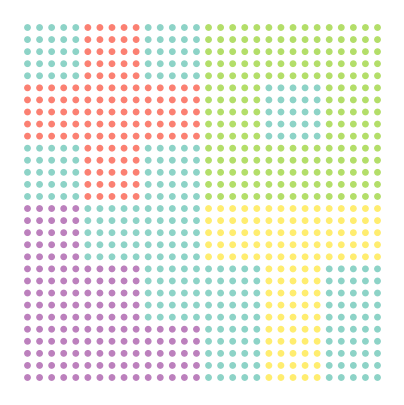

In [4]:
data, labels = make_dataset(block_size=5, return_tensor=True)
show_dataset(data, labels)

In [5]:
import torch

arr = torch.arange(10)
torch.is_complex(arr)

False

UNCP:   0%|          | 0/10 [00:00<?, ?it/s]/var/folders/qn/z7rm9myd1k73f0l5v7df09wc0000gn/T/ipykernel_92023/674214223.py:69: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4416.)
  logprobs[:-1] = self._lq_model(embeddings[:-1].relu())[..., 0].T
UNCP: 100%|██████████| 10/10 [02:50<00:00, 17.04s/it]


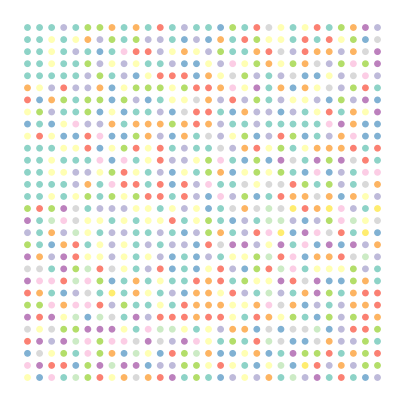

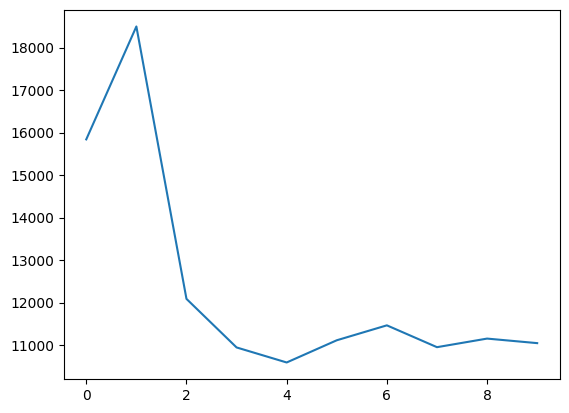

In [5]:
model = UNCP()
model.fit(data, n_steps=10)
show_dataset(data, model.labels_)
plt.show()
arr = torch.arange(len(model.log_))
plt.plot(arr, model.log_)
plt.show()